In [12]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from collections import Counter
import transformers
from transformers import pipeline
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re
import comprehension_model
from datasets import Dataset
import pandas as pd

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12399
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2673
    })
})


In [14]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [15]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [ ]:
exbert_tokenizer = AutoTokenizer.from_pretrained("exbert_tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/alvis_project/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [ ]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [ ]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

In [ ]:
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset,data_collator)

In [ ]:
from datasets import Dataset
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
small_valid_dataset = preprocessing.create_deterministic_eval_dataset(valid_dataset.select(range(10000)),data_collator)
small_valid_dataloader=preprocessing.create_dataloader(small_valid_dataset,64,default_data_collator)
                                                                      

In [ ]:
word = "Statsrådet"
token_id = tokenizer.convert_tokens_to_ids(word)

In [ ]:
def special_token(token,example):
    return token in example['labels']

In [ ]:
valid_filtered_dataset = valid_dataset.filter(lambda example : special_token(token_id,example))

In [ ]:
valid_filtered_dataset

In [ ]:

valid_filtered_dataloader=preprocessing.create_dataloader(valid_filtered_dataset,64,default_data_collator)

In [ ]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

In [16]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500")
model_hugging_face=model_hugging_face.to(device)

In [17]:
model_exbert = AutoModelForMaskedLM.from_pretrained("/home/laurinemeier/swerick/exbert-finetuned-imdb/checkpoint-6054000")
model_exbert=model_exbert.to(device)

In [10]:
import transformers
config = transformers.BertConfig.from_pretrained("alvis_project/pretraining_from_scratch/checkpoint-5258900")
mosaicBert = AutoModelForMaskedLM.from_pretrained("alvis_project/pretraining_from_scratch/checkpoint-5258900",config=config,trust_remote_code=True)
mosaicBert.to(device)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-5258900/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50328, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out

In [ ]:

  
valid_sentence_filtered = valid_filtered_dataset.map(lambda example : preprocessing.get_context_with_mask(example,token_id,tokenizer))

In [ ]:
def get_embeddings_bis(model,dataloader, tokenizer,token_id):
    model.eval()
    model.to(device)
    layerwise_embeddings = [[] for _ in range(model.config.num_hidden_layers + 1)]
    preds=[]
    for batch in dataloader :
        tokens={key : value.to(device) for key,value in batch.items()}
        if token_id not in list(batch["labels"][0]):
            continue
        index=list(batch["labels"][0]).index(token_id)
        outputs= model(input_ids=tokens["input_ids"],attention_mask=tokens["attention_mask"],labels=tokens["labels"],output_hidden_states=True)
        preds.append(torch.argmax(F.softmax(outputs.logits.squeeze(0)[index])))
        hidden_states = outputs.hidden_states  # tuple of (layer+1) tensors, each of shape (batch_size, seq_len, hidden_size)
        for i, hidden_state in enumerate(hidden_states):
            masked_embeddings = hidden_state[:, index, :].detach().cpu().numpy()  # Extract [CLS] token
            layerwise_embeddings[i].append(masked_embeddings)
    return [np.vstack(layer) for layer in layerwise_embeddings],preds


In [ ]:
from sklearn.decomposition import PCA
inputs = valid_sentence_filtered[3]
print(tokenizer.decode(inputs["input_ids"]))
token = {key: torch.tensor(value, dtype=torch.long).unsqueeze(0).to(device) for key,value in inputs.items()}
outputs = model_hugging_face(input_ids=token["input_ids"],attention_mask=token["attention_mask"],labels=token["labels"],output_hidden_states=True)
outputs2=model_kb(input_ids=token["input_ids"],attention_mask=token["attention_mask"],labels=token["labels"],output_hidden_states=True)
tokens = tokenizer.convert_ids_to_tokens(token["input_ids"].squeeze())
index=inputs["labels"].index(token_id)
hidden_states = outputs.hidden_states
hidden_states_kb = outputs2.hidden_states
last_hidden_state = hidden_states[-1].squeeze().detach().cpu().numpy()
print(tokenizer.decode(torch.argmax(outputs.logits.squeeze()[index])))
print(tokenizer.decode(torch.argmax(outputs2.logits.squeeze()[index])))
def plot_pca_hidden_state(hidden_state,tokens,number):
    pca = PCA(n_components=2)
    reduced_states = pca.fit_transform(hidden_state.squeeze().detach().cpu().numpy())

    # Préparer la figure pour la visualisation
    plt.figure(figsize=(14, 8))
    for i, token in enumerate(tokens):
        if token in ["[CLS]","[SEP]"]:
            color = 'green'  # Token spécial
        elif token == '[MASK]':
            color = 'purple'  # Token masqué
        else:
            color = 'cyan'  # Token de contexte
        
        plt.scatter(reduced_states[i, 0], reduced_states[i, 1], c=color, label=token)
        plt.text(reduced_states[i, 0], reduced_states[i, 1], token, fontsize=9)

    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"PCA of hidden state for one sentence at layer {number} ")
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Token de Contexte'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Token Spécial'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Token Masqué')
    ], loc='upper right')

    plt.show()

for j in range(13):
    print("hugging face")
    plot_pca_hidden_state(hidden_states[j],tokens,j)
    print("kb")
    plot_pca_hidden_state(hidden_states_kb[j],tokens,j)

In [ ]:
#PCA hidden states
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
text = "Herr [MASK] von Ehrenheim : Anledningen till den framställning "
inputs = tokenizer(text, return_tensors='pt').to(device)
input_eb=exbert_tokenizer(text,return_tensors='pt').to(device)
input_spa = swerick_tokenizer(text,return_tensors='pt').to(device)

outputs = model_kb(**inputs,output_hidden_states=True)
outputs_hugging = model_hugging_face(**inputs,output_hidden_states=True)
output_eb=model_exbert(**input_eb,output_hidden_states=True)
output_spa=mosaicBert(**input_spa,output_hidden_states=True)
print(output_spa)
all_hidden_states = outputs.hidden_states
all_hidden_states_cpt = outputs_hugging.hidden_states
all_hidden_states_eb = output_eb.hidden_states
all_hidden_states_spa = output_spa.hidden_states

index=2
token_hidden_states = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states]
token_hidden_states_cpt = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_cpt]
token_hidden_states_eb = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_eb]
#token_hidden_states_spa = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_spa]

pca_2d = PCA(n_components=2)
token_hidden_states_2d = pca_2d.fit_transform(token_hidden_states)
token_hidden_states_cpt_2d = pca_2d.fit_transform(token_hidden_states_cpt)
token_hidden_states_eb_2d = pca_2d.fit_transform(token_hidden_states_eb)
#token_hidden_states_spa_2d = pca_2d.fit_transform(token_hidden_states_spa)

pca_3d = PCA(n_components=3)
token_hidden_states_3d = pca_3d.fit_transform(token_hidden_states)
token_hidden_states_cpt_3d = pca_3d.fit_transform(token_hidden_states_cpt)
token_hidden_states_eb_3d = pca_3d.fit_transform(token_hidden_states_eb)
#token_hidden_states_spa_3d = pca_3d.fit_transform(token_hidden_states_spa)

plt.figure(figsize=(10, 7))
for i in range(len(token_hidden_states_2d)):
    plt.scatter(token_hidden_states_2d[i, 0], token_hidden_states_2d[i, 1], label=f'Layer {i}')
  
plt.plot(token_hidden_states_2d[:, 0], token_hidden_states_2d[:, 1], linestyle='-', marker='o')
plt.plot(token_hidden_states_cpt_2d[:, 0], token_hidden_states_cpt_2d[:, 1], linestyle='-', marker='o',color='red',label='cptBERT')
plt.plot(token_hidden_states_eb_2d[:, 0], token_hidden_states_eb_2d[:, 1], linestyle='-', marker='o',color='green',label='sBERTex')
#plt.plot(token_hidden_states_spa_2d[:, 0], token_hidden_states_spa_2d[:, 1], linestyle='-', marker='o',color='black',label='sparBERT')
plt.title(f'2D Projection of Hidden States of Token {tokenizer.decode(inputs["input_ids"][0][index])} through layers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Visualisation en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(token_hidden_states_3d)):
    ax.scatter(token_hidden_states_3d[i, 0], token_hidden_states_3d[i, 1], token_hidden_states_3d[i, 2], label=f'Layer {i}')
ax.plot(token_hidden_states_3d[:, 0], token_hidden_states_3d[:, 1], token_hidden_states_3d[:, 2], linestyle='-', marker='o')
ax.plot(token_hidden_states_cpt_3d[:, 0], token_hidden_states_cpt_3d[:, 1], token_hidden_states_cpt_3d[:, 2], linestyle='-', marker='o',color='red',label='cptBERT')
ax.plot(token_hidden_states_eb_3d[:, 0], token_hidden_states_eb_3d[:, 1], token_hidden_states_eb_3d[:, 2], linestyle='-', marker='o',color='green',label='sBERTex')
#ax.plot(token_hidden_states_spa_3d[:, 0], token_hidden_states_spa_3d[:, 1], token_hidden_states_spa_3d[:, 2], linestyle='-', marker='o',color='black',label='sparBERT')
ax.set_title(f'3D Projection of Hidden States of Token {tokenizer.decode(inputs["input_ids"][0][index])} through layer')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [ ]:
for layer in range(13):
        combined_embeddings = np.concatenate([baseline_embeddings[layer], finetuned_embeddings[layer]])
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(combined_embeddings)
        plt.figure(figsize=(10, 8))
        for i, color in enumerate(['blue', 'red', 'orange', 'green']):
            indices = [j for j, c in enumerate(colors) if c == color]
            plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=color, alpha=0.5, edgecolors='w', s=50)

        plt.title('t-SNE of Word Embeddings with Classification Results')
        plt.legend(loc='best')
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
num_words=500
embedding_matrix_kb = model_kb.bert.embeddings.word_embeddings.weight.detach().cpu()
embedding_matrix_cpt= model_hugging_face.bert.embeddings.word_embeddings.weight.detach().cpu()
#words_of_interest = ['##nader', '##varo', '##sapparat', 'ned', 'begär', '##ier', '##vens', 'replik', '##skri', '##ads', 'regionerna', '##skar', '##ositionen', 'försäkra', '##vot', '##fri', '##näringen', '##oko', '##olin', 'fonden', '##äck', '##skill', '##kontakt', '##grip', '##raftt', 'Fru', '##mäl', '##vari', 'Statsrådet', 'Utskottet', '##£', '##ati', '##rift', 'Full', '##farlig', '##eminister', '##iter', 'Pro', '##ande', 'någonting', 'Hultsfred', '##ötet', '##igen', '##speriod', 'Kungl', '##pekt', 'Onsdagen', '##kning', '##£', 'Kungl', 'Flott', '##sättas', '##arbetar', '718', '##mäter', '##mt', 'fi', '##NE', 'godkännas', 'JOHANSSON', 'Onsdagen', '##taga', 'Måndagen', 'Nr', '##hai', 'talman', 'Riksdagen']
#word_indices = [tokenizer.vocab[word] for word in words_of_interest if word in tokenizer.vocab]
words_of_interest= list(tokenizer.vocab.keys())[:num_words]
selected_embeddings_kb = embedding_matrix_kb[:num_words, :]
selected_embeddings_cpt = embedding_matrix_cpt[:num_words, :]
tsne = TSNE(n_components=2, random_state=42,perplexity=30)
embedding_2d = tsne.fit_transform(selected_embeddings_kb)

# Tracer les embeddings 2D
plt.figure(figsize=(10, 10))
for i, word in enumerate(words_of_interest):
    x, y = embedding_2d[i, :]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)

plt.title('2D t-SNE Representation of Word Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

embedding_cpt = tsne.fit_transform(selected_embeddings_cpt)
plt.figure(figsize=(10, 10))
for i, word in enumerate(words_of_interest):
    x, y = embedding_cpt[i, :]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)

plt.title('2D t-SNE Representation of Word Embeddings for cptBERT')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

cls.predictions.transform.LayerNorm.weight


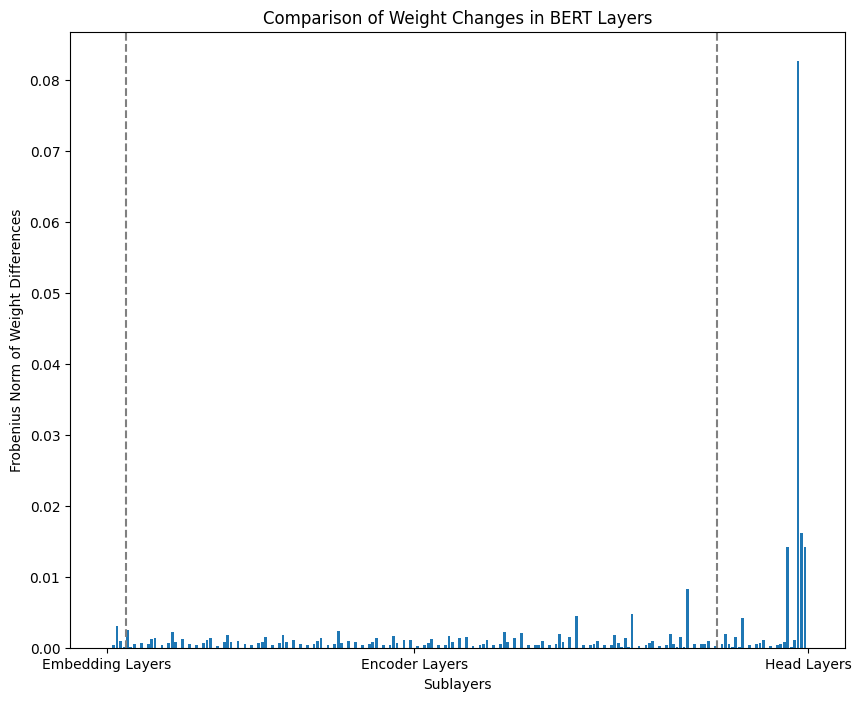

In [18]:
# Comparaison of weights for different model
import numpy as np

weights_kb = comprehension_model.get_model_weights(model_kb)
weights_finetuned = comprehension_model.get_model_weights(model_hugging_face)

weight_diffs = {}
for key in weights_kb.keys():
    weight_diffs[key] = weights_finetuned[key] - weights_kb[key]
    if (np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) > 0.04 :
        print(key)
    #     print(np.linalg.norm(weight_diffs[key],2))
    #     print(weight_diffs[key].size)
    #     print( np.linalg.norm(weight_diffs[key])/weight_diffs[key].size)
    

weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy()
norms = [(np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) for key in weight_diffs.keys()]
embedding_indices = [list(range(0, 5))]
encoder_layers= list(range(5 ,5 +16*(11)))  # Adjust based on actual sublayers
head_layer_indices = list(range(181, len(norms)))

xticks_positions = [0, len(encoder_layers)//2 + len(embedding_indices), len(norms)-1]
xticks_labels = ['Embedding Layers', 'Encoder Layers', 'Head Layers']

plt.figure(figsize=(10, 8))
plt.bar(range(len(norms)), norms)
plt.axvline(x=5.5, color='grey', linestyle='--')
plt.axvline(x=len(embedding_indices) + len(encoder_layers) - 0.5, color='grey', linestyle='--')
plt.xticks(xticks_positions, xticks_labels, rotation=0)
plt.ylabel('Frobenius Norm of Weight Differences')
plt.xlabel('Sublayers')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show()  

In [ ]:
model_hugging_face.state_dict()["bert.encoder.layer.0.attention.self.key.weight"].shape

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('weight_distribution_scratch.pdf') as pdf:
    for name,param in mosaicBert.named_parameters():
        layer_name = name
        print(name)
        split_name =name.split('.')
        layer = split_name[3]
        print(layer)
        #comprehension_model.plot_weight_distributions(model_hugging_face, model_kb, layer_name)
        if "attention.self.Wqkv"  in name and "weight" in name:
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.query.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][:768,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.key.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][768:1536,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.value.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][1536:,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
        elif  "attention.self.Wqkv" in name and "bias" in name :
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.query.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][:768].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.key.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][768:1536].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.value.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][1536:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close() 
        elif "mlp.gated_layers"  in name :
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.intermediate.dense.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "mlp.wo" in name :
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.output.dense.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "mlp.layernorm"  in name :
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.output.LayerNorm.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "cls.predictions.decoder" in name:
            continue
            
        else :
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            weights2 = model_kb.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()

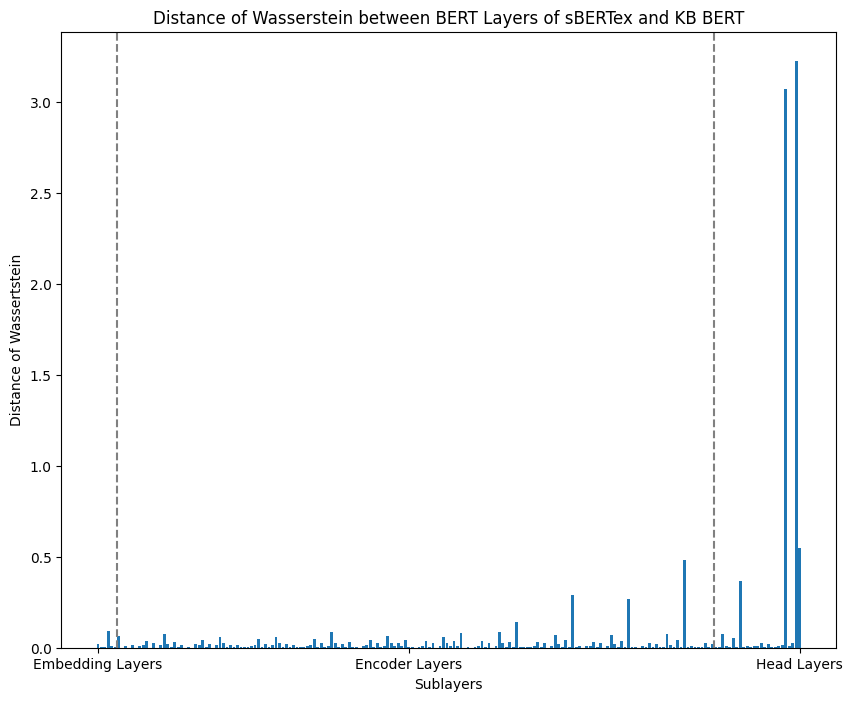

In [31]:
from scipy.stats import wasserstein_distance

def extract_parameters(model):
    parameters = {}
    for name, param in model.named_parameters():
        parameters[name] = param.detach().cpu().numpy().flatten()
    return parameters

params_model_1 = extract_parameters(model_kb)
params_model_2 = extract_parameters(model_exbert)

# Calculer la distance de Wasserstein pour chaque paramètre entre les deux modèles
distances = []
param_names = []

for param_name in params_model_1:
        distance = wasserstein_distance(params_model_1[param_name], params_model_2[param_name])
        distances.append(distance)
        param_names.append(param_name)

# Créer un graphique de la distance de Wasserstein pour chaque paramètre
embedding_indices = [list(range(0, 5))]
encoder_layers= list(range(5 ,5 +16*(11)))  # Adjust based on actual sublayers
head_layer_indices = list(range(181, len(distances)))
xticks_positions = [0, len(encoder_layers)//2 + len(embedding_indices), len(distances)-1]
xticks_labels = ['Embedding Layers', 'Encoder Layers', 'Head Layers']
plt.figure(figsize=(10, 8))
plt.bar(range(len(distances)), distances)
plt.axvline(x=5.5, color='grey', linestyle='--')
plt.axvline(x=len(embedding_indices) + len(encoder_layers) - 0.5, color='grey', linestyle='--')
plt.xticks(xticks_positions, xticks_labels, rotation=0)
plt.ylabel('Distance of Wassertstein')
plt.xlabel('Sublayers')
plt.title('Distance of Wasserstein between BERT Layers of sBERTex and KB BERT')
plt.show()  

['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


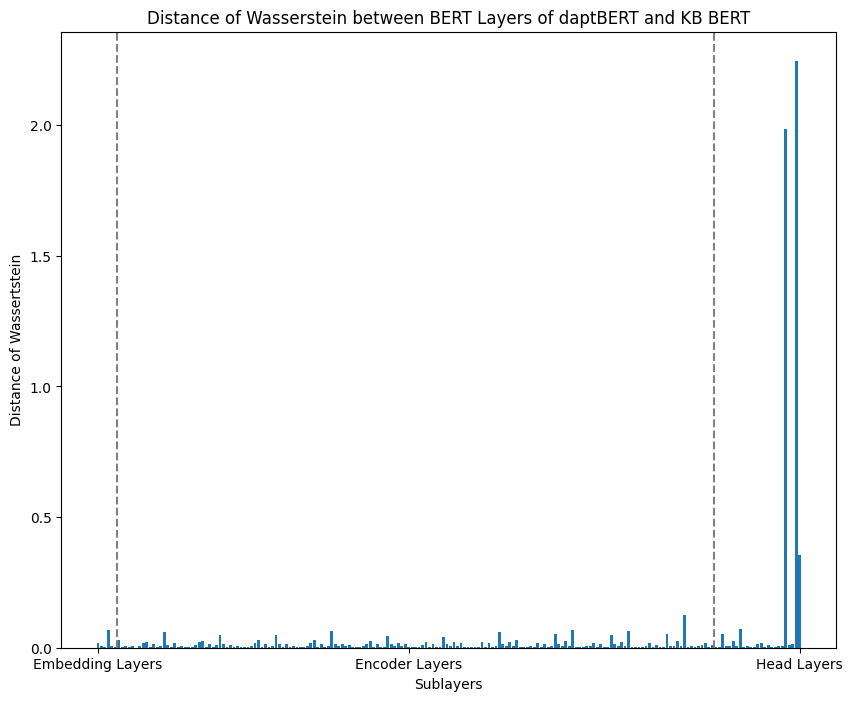

In [30]:
high_peak_indices = [i for i, dist in enumerate(distances) if dist > 0.2]
high_peak_params = [param_names[i] for i in high_peak_indices]
print(high_peak_params)
embedding_indices = [list(range(0, 5))]
encoder_layers= list(range(5 ,5 +16*(11)))  # Adjust based on actual sublayers
head_layer_indices = list(range(181, len(distances)))
xticks_positions = [0, len(encoder_layers)//2 + len(embedding_indices), len(distances)-1]
xticks_labels = ['Embedding Layers', 'Encoder Layers', 'Head Layers']
plt.figure(figsize=(10, 8))
plt.bar(range(len(distances)), distances)
plt.axvline(x=5.5, color='grey', linestyle='--')
plt.axvline(x=len(embedding_indices) + len(encoder_layers) - 0.5, color='grey', linestyle='--')
plt.xticks(xticks_positions, xticks_labels, rotation=0)
plt.ylabel('Distance of Wassertstein')
plt.xlabel('Sublayers')
plt.title('Distance of Wasserstein between BERT Layers of daptBERT and KB BERT')
plt.show()  

In [ ]:
for name,param in model_exbert.named_parameters():
    print(name)

In [ ]:

layer_name = "cls.predictions.transform.dense.weight"

weights2 = model_kb.state_dict()[layer_name].flatten().cpu().numpy()
weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
plt.figure(figsize=(10, 5))
plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
plt.title(f"Weight Distribution Comparison for {layer_name} for SparBERT")
plt.xlabel("Weight values")
plt.ylabel("Frequency")
plt.legend()
plt.show()
plt.close()

In [ ]:
import torch.nn.functional as F
print(hidden_states1[0].shape)
i=8
hidden_states1,logits1=get_embeddings_bis(model_kb,valid_sentence_filtered [i],tokenizer)
hidden_states2,logits2=get_embeddings_bis(model_hugging_face,valid_sentence_filtered [i],tokenizer)
#masked_positions =[idx for idx, token in enumerate(valid_filtered_dataset[i]['input_ids']) if token == tokenizer.mask_token_id]
index = valid_sentence_filtered [i]['labels'].index(token_id)
print(token_id)
print(tokenizer.decode(valid_sentence_filtered[i]['input_ids']))
print(tokenizer.decode(torch.argmax(F.softmax(logits1.squeeze()[index], dim=-1)).item()))
print(tokenizer.decode(torch.argmax(F.softmax(logits2.squeeze()[index], dim=-1)).item()))
for j in range(len(hidden_states1)) :
    print(tokenizer.decode((valid_sentence_filtered[i]['labels'][index])))
    print('hidden layer ',j)
    plt.figure(figsize=(10,6))
   #plt.hist(hidden_states1[j][0][index].detach().cpu().numpy(), bins=100, alpha=0.5, label='Baseline Model')
    plt.hist(hidden_states1[j][0][0].detach().cpu().numpy(), bins=100, alpha=0.5, label='Baseline Model cls')
    #plt.hist(hidden_states2[j][0][index].detach().cpu().numpy(), bins=100, alpha=0.5, label='Fine-tuned Model')
    plt.hist(hidden_states2[j][0][0].detach().cpu().numpy(), bins=100, alpha=0.5, label='finetuned Model cls')
    plt.xlabel('weight')
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

In [ ]:
import numpy as np 
checkpoint_directory = "/home/laurinemeier/swerick/finetuning/finetuning_hugging_whitespace-finetuned-imdb"
checkpoint_files = os.listdir(checkpoint_directory)
checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
selected_checkpoints = [checkpoint_files[i] for i in range(0, len(checkpoint_files), 10)]
weight1 = model_kb.state_dict()["bert.embeddings.word_embeddings.weight"].flatten().cpu().numpy()
print("std kb", np.std(weight1))
for name in selected_checkpoints :
    print(name)
    model_hugging =AutoModelForMaskedLM.from_pretrained(checkpoint_directory + '/'+name)
    weights2 = model_hugging.state_dict()["bert.embeddings.word_embeddings.weight"].flatten().cpu().numpy()
    print(np.std(weights2))
    model_hugging.to(device)
    comprehension_model.plot_weight_distributions(model_hugging, model_kb, "bert.embeddings.word_embeddings.weight")

In [ ]:
hidden_states1 = comprehension_model.get_embeddings(model_kb, small_valid_dataloader, tokenizer)
hidden_states2 = comprehension_model.get_embeddings(model_hugging_face, small_valid_dataloader, tokenizer)

for i in range(len(hidden_states1)):
        plt.figure(figsize=(10, 5))
        plt.hist(hidden_states1[i].flatten(), bins=100, alpha=0.5, label='Baseline Model')
        plt.hist(hidden_states2[i].flatten(), bins=100, alpha=0.5, label='Fine-tuned Model')
        plt.title(f"Hidden States Distribution Comparison for Layer {i}")
        plt.xlabel("Hidden States Values")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

In [ ]:
#Evolution of a specific layer through epochs
checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
comprehension_model.evolution_specific_layer_weight(chekpoint_directory)

Study of Word Embedding

In [ ]:

def plot_results(mean_similarities,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(mean_similarities)), mean_similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_hidden_states,mean_similarities_attention,diff_tot = comprehension_model.extract_and_compare_activations(model_kb, model_hugging_face, valid_filtered_dataloader,token_id)
print("Layer-wise cosine similarities:", mean_similarities_hidden_states)


plot_results(mean_similarities_hidden_states)
plot_results(mean_similarities_attention,'Attention Layer Number',title='Average Attention Layer-wise Cosine Similarity between Attention values Across Validation Dataset')
plot_results(diff_tot,'Layer Number',title='Average Norm difference between hidden states  Across Validation Dataset for token {words}')



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()


# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_results(similarities, x_label='Layer Number', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

def compare_ffn_contributions(model_pre, model_post, dataloader):
    similarities_pre = []
   #similarities_post = []
    
    for batch in dataloader:
        batch = {k: batch[k].to(device) for k in batch.keys()}
        
        with torch.no_grad():
            pre_output = model_pre(**batch, output_hidden_states=True)
            pre_activations = pre_output.hidden_states
            post_output = model_post(**batch, output_hidden_states=True)
            post_activations = post_output.hidden_states
    
        pre_contribution = [(pre_activations[layer+1] -pre_activations[layer]) for layer in range(len(pre_activations)-1)]
        post_contribution = [(post_activations[layer+1] - post_activations[layer]) for layer in range(len(post_activations)-1)]

        pre_activation = [cosine_similarity(pre_contribution[i],post_contribution[i]) for i in range (len(pre_contribution))]
       # post_activation = [cosine_similairity(post_contribution[i] for i in range (len(post_contribution)))]
        similarities_pre.append(pre_activation)
       # similarities_post.append(post_contribution)
        
        del pre_activations
        del post_activations
        del pre_output
        del post_output
    
    similarities_pre = np.mean(np.array(similarities_pre), axis=0)
   # similarities_post = np.mean(np.array(similarities_post), axis=0)
    
    return similarities_pre
# Example usage
mean_similarity_pr = compare_ffn_contributions(model_kb, model_hugging_face, small_valid_dataloader)

plot_results(mean_similarity_pr, x_label='Layer n+1 - Layer n', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity for differences consecutive layers of KB Bert Model and cptBERT')
#plot_results(mean_similarity_post, label='Layer n+1 - Layer n', x_label='Layer n+1 - Layer n', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity for Finetuned Model')


In [ ]:
import torch.nn.functional as F
import numpy as np

# see if final layers is similar


def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()


def interpolate_to_length(tensor, target_length):
    # Interpolation linéaire pour redimensionner le tenseur à la longueur cible
    current_length = tensor.shape[1]
    if current_length == target_length:
        return tensor
    # Créer un tenseur avec la longueur cible en utilisant l'interpolation linéaire
    interpolated_tensor = F.interpolate(tensor.transpose(1, 2), size=target_length, mode='linear', align_corners=False).transpose(1, 2)
    return interpolated_tensor

def plot_results(similarities, x_label='Layer Number', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()
    
model_hugging_face.to(device)
model_exbert.to(device)
#mosaicBert.to(device)  
model_kb.to(device)




cosine_cpt_final=[]
cosine_eb_final=[]
cosine_spa_final=[]
hidden_states=[]
cosine_embedding=[]
diff_final_kb=[]
diff_final_eb=[]
embedding_cpt = model_hugging_face.bert.embeddings
embedding_kb=model_kb.bert.embeddings

# random_vector = torch.randn_like(hidden_states[0]).to(device)
torch.manual_seed(33)
for layer in range(12):

    cosine_cpt=[]
    cosine_eb=[]
    cosine_spa=[]
    diff_kb=[]
    diff_eb=[]
    last_layer_kb = model_kb.bert.encoder.layer[layer]
    last_layer_cpt = model_hugging_face.bert.encoder.layer[layer]
    last_layer_eb=model_exbert.bert.encoder.layer[layer]
       
    for batch in small_valid_dataloader :
        batch={key:value.to(device) for key,value in batch.items()}
        with torch.no_grad():
            output=model_kb(**batch,output_hidden_states=True)
        if layer ==0:
            embedding = embedding_cpt(batch["input_ids"])
            
        hidden_states=output.hidden_states[layer].to(device)

      
        # if layer ==0:
        #     embedding = embedding_cpt(random_embedding)  
        #     embeddingkb= embedding_kb(random_embedding)
        hs_kb=last_layer_kb(hidden_states)
        hs_cpt=last_layer_cpt(hidden_states)
        hs_eb=last_layer_eb(hidden_states)
        
        
                
        # if layer==0:
        #     cosine_embedding.append(cosine_similarity(embeddingkb,embedding))
            
        cosine_cpt.append(cosine_similarity(hs_kb[0],hs_cpt[0]))
        cosine_eb.append(cosine_similarity(hs_kb[0],hs_eb[0]))
        cosine_spa.append(cosine_similarity(hs_eb[0],hs_cpt[0]))
        diff_kb.append(cosine_similarity(hs_kb[0]-hidden_states,hs_cpt[0]-hidden_states))
        diff_eb.append(cosine_similarity(hs_kb[0]-hidden_states,hs_eb[0]-hidden_states))
        # if layer==0:
        #     cosine_cpt_final.append(np.mean(cosine_embedding))
    cosine_cpt_final.append(np.mean(cosine_cpt))
    cosine_eb_final.append(np.mean(cosine_eb))
    cosine_spa_final.append(np.mean(cosine_spa,axis=0))
    diff_final_kb.append(np.mean(diff_kb))
    diff_final_eb.append(np.mean(diff_eb))
    
    print(np.mean(cosine_cpt))
    print(np.mean(cosine_eb))   
            

plot_results(cosine_cpt_final,x_label='Layer',title='Avg cosine similarity between KB bert and cptBERT without propagation')
plot_results(cosine_eb_final,x_label='Layer',title='Avg cosine similarity between KB bert and sBERTex without propagation')
plot_results(cosine_spa_final,x_label='Layer',title='Avg cosine similarity between cptBERT and sBERTex without propagation')
plot_results(diff_final_kb,x_label='Layer',title='Avg cosine similarity between differences of consecutives layers cptBERT and KB bert without propagation')
plot_results(diff_final_eb,x_label='Layer',title='Avg cosine similarity between differences of consecutives layers sBERTex and KB bert without propagation')
# # print("cosine similarity spa",np.mean(cosine_spa,axis=0))
    
# sentence = "Herr [MASK] von Ehrenheim : Äfven"
# input_kb=tokenizer(sentence,return_tensors='pt').to(device)
# input_eb=exbert_tokenizer(sentence,return_tensors='pt').to(device)
# model_kb.to(device)
# model_exbert.to(device)


# output1=model_kb(**input_kb,output_hidden_states=True)
# output2=model_exbert(**input_eb,output_hidden_states=True)
# pre_activations = output1.hidden_states
# post_activation=output2.hidden_states

# target_length=len(pre_activations[0][0])
# print(target_length)

# pre_contribution = [interpolate_to_length((pre_activations[layer+1] -pre_activations[layer]),target_length) for layer in range(len(pre_activations)-1)]
# post_contribution = [interpolate_to_length((post_activation[layer+1] - post_activation[layer]),target_length) for layer in range(len(post_activation)-1)]

# cosine_activation = [cosine_similarity(pre_contribution[i],post_contribution[i]) for i in range (len(pre_contribution))]


# plot_results(cosine_activation,x_label="Layer",y_label="Average Cosine Similairyt difference")






In [ ]:
import torch.nn.functional as F

text="Herr [MASK] von Ehrenheim : Anledningen till den framställning"
input_kb=tokenizer(text,return_tensors='pt').to(device)
output=model_kb(**input_kb,output_hidden_states=True)

hidden_states=output.hidden_states[-1].to(device)
head_layer_kb=model_kb.cls
head_layer_cpt=model_hugging_face.cls
head_layer_eb=model_exbert.cls
head_layer_spa=mosaicBert.cls
output_kb = head_layer_kb(hidden_states)
output_cpt = head_layer_cpt(hidden_states)
output_eb = head_layer_eb(hidden_states)
output_spa=head_layer_spa(hidden_states)
print(output_kb.shape)

softmax_probs_kb = F.softmax(output_kb.squeeze()[2], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
print(sorted_tokens_kb)

softmax_probs_kb = F.softmax(output.logits.squeeze()[2], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
print(sorted_tokens_kb)

softmax_probs_cpt = F.softmax(output_cpt.squeeze()[2], dim=-1)
sorted_probs_cpt, sorted_indices_cpt = torch.sort(softmax_probs_cpt, descending=True)
sorted_tokens_cpt= [tokenizer.decode([idx]) for idx in sorted_indices_cpt[:10]]
print(sorted_tokens_cpt)

softmax_probs_eb = F.softmax(output_eb.squeeze()[2], dim=-1)
sorted_probs_eb, sorted_indices_eb = torch.sort(softmax_probs_eb, descending=True)
sorted_tokens_eb = [exbert_tokenizer.decode([idx]) for idx in sorted_indices_eb[:10]]
print(sorted_tokens_eb)


softmax_probs_spa = F.softmax(output_spa.squeeze()[2], dim=-1)
sorted_probs_spa, sorted_indices_spa = torch.sort(softmax_probs_spa, descending=True)
sorted_tokens_spa = [swerick_tokenizer.decode([idx]) for idx in sorted_indices_spa[:10]]
print(sorted_tokens_spa)

In [ ]:
# Cosine similarity between layers
from datasets import Dataset
import torch
import numpy as np




def extract_and_compare_feed_forward_weights(model_pre, model_post, dataloader):
    similarities_attention = {}
    similarities_query = {}
    similarities_key = {}
    similarities_value = {}
    for (name_base, param_base), (name_fine, param_fine) in zip(model_kb.named_parameters(), model_hugging_face.named_parameters()):
        if "cls.predictions.transform.dense.weight" in name_base :
            sim = cosine_similarity(param_base, param_fine)
            similarities_attention[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")
        if  "cls.predictions.transform.dense.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_query[name_base]=sim
        if  "attention.self.key.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_key[name_base]=sim
        if  "attention.self.value.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_value[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")

    return similarities_attention,similarities_query,similarities_key,similarities_value
       
def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()



def plot_results(similarities,label,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b',)
    plt.xlabel(label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_attention,mean_similarities_query,mean_similarities_key,mean_similarities_value = extract_and_compare_feed_forward_weights(model_kb, model_hugging_face, valid_dataloader)
similarity_attention=[mean_similarities_attention[i] for i in mean_similarities_attention.keys()]
similarity_query=[mean_similarities_query[i] for i in mean_similarities_query.keys()]
similarity_key=[mean_similarities_key[i] for i in mean_similarities_key.keys()]
similarity_value=[mean_similarities_value[i] for i in mean_similarities_value.keys()]



plot_results(similarity_attention,label = mean_similarities_attention.keys(),title='layer wise cosine similarity between weights for attention.output.dense')
plot_results(similarity_query,label = mean_similarities_query.keys(),title='layer wise cosine similarity between weights for attention.self.query')
plot_results(similarity_key,label = mean_similarities_key.keys(),title='layer wise cosine similarity between weights for attention.self.key')
plot_results(similarity_value,label = mean_similarities_value.keys(),title='layer wise cosine similarity between weights for attention.self.value')


In [7]:
def get_embeddings(text,model):

    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs,output_hidden_states=True)
        
    embeddings = outputs.hidden_states
    return embeddings

In [ ]:
embeddings_train = [get_embeddings(phrase,model_kb) for phrase in date_dataset["train"]["content"][:5]]
print(len(embeddings_train))
print(len(embeddings_train[0]))
embeddings_test = [get_embeddings(phrase,model_kb) for phrase in date_dataset["test"]["content"][:5]]

In [6]:
data_files = {"train": "evaluation/swerick_data_party_train.pkl", "test": "evaluation/swerick_data_party_test.pkl"}
party_dataset = load_dataset("pandas",data_files=data_files)
print(party_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'Note', 'id', 'party', 'gender'],
        num_rows: 3378877
    })
    test: Dataset({
        features: ['protocole', 'Note', 'id', 'party', 'gender'],
        num_rows: 725974
    })
})


In [7]:
def extract_date_from_filename(protocole):
    match = re.search(r'/(\d+)/', protocole)
    if match:
        year = match.group(1)
        return int(year[:4])
    else:
        return None
dates = [extract_date_from_filename(row['protocole']) for row in party_dataset['train']]
dates_test = [extract_date_from_filename(row['protocole']) for row in party_dataset['test']]
party_dataset['train'] = party_dataset['train'].add_column('date', dates)
party_dataset['test'] = party_dataset['test'].add_column('date', dates_test)

In [8]:
def determine_reform(example):
    example['reform'] = 0 if example['date'] <= 1912 else 1
    return example

# Appliquer la fonction à chaque ligne du dataset
date_dataset = party_dataset.map(determine_reform)

In [15]:
date_dataset["train"] = date_dataset["train"].shuffle(seed=42)
date_dataset["test"] = date_dataset["test"].shuffle(seed=42)
print(date_dataset["train"][:10]["reform"])
print(date_dataset["train"][:10]["reform"])

[1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1]


In [7]:
#df =Dataset.from_dict(date_dataset["train"][:1000]).to_pandas()
df = pd.read_csv("swerick_subsetdata_party_train.csv")
print(df["tag"])
# df= df.rename(columns={"Note": "content", "reform": "tag"})
# # Save the filtered DataFrame to a CSV file
# df.to_csv("swerick_subsetdata_party_train.csv", index=False)

0      1
1      1
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: tag, Length: 1000, dtype: int64


In [22]:
#Edge probing : predicting noun  
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
        
def extract_and_classify(dataset_train,dataset_test, model,length):
    layer_accuracies = []
    with torch.no_grad():
        for layer_index in range(model.config.num_hidden_layers + 1):  # Include the embedding layer
            embeddings_train = [get_embeddings(phrase,model_kb) for phrase in dataset_train['Note'][:length]]
            train_embeddings =[sentence[layer_index].cpu().numpy().flatten() for sentence in embeddings_train] 
            train_labels = dataset_train["reform"][:length]
            print(train_labels)
            embeddings_test = [get_embeddings(phrase,model_kb) for phrase in dataset_test["Note"][:length]]
            test_embeddings =[sentence[layer_index].cpu().numpy().flatten() for sentence in embeddings_test] 
            test_labels = dataset_test["reform"][:length]

            clf = LogisticRegression()
            clf.fit(train_embeddings, train_labels)
            y_pred = clf.predict(test_embeddings)

            # Calculate accuracy
            accuracy = accuracy_score(test_labels, y_pred)
            layer_accuracies.append((layer_index, accuracy))
    
    return layer_accuracies


accuracies = extract_and_classify(date_dataset["train"],date_dataset["test"], model_kb,10)

# Output the accuracies for each layer
for layer, acc in accuracies:
    print(f"Layer {layer}: Accuracy {acc}")




['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post

In [24]:
accuracies = extract_and_classify(date_dataset["train"],date_dataset["test"], model_hugging_face,10)
for layer, acc in accuracies:
    print(f"Layer {layer}: Accuracy {acc}")

['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post', 'post', 'post', 'post']
['post', 'post', 'pre', 'post', 'post', 'pre', 'post

In [ ]:
train_embeddings =[sentence[1] for sentence in embeddings_train] 
len(train_embeddings[0][0][0])

In [ ]:
input = date_dataset["train"]["content"][0]
input = tokenizer(input,return_tensors="pt", padding="max_length", truncation=True, max_length=512)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
input=data_collator([input])
collated_inputs = {key: value.squeeze(1) for key, value in input.items()}
output =model_kb(collated_inputs["input_ids"],attention_mask=collated_inputs["attention_mask"],labels =collated_inputs["labels"],output_hidden_states=True)
hidden_states = output.hidden_states



In [14]:
def extract_features(examples,model,tokenizer):
  # take a batch of images
  images = examples['Note']
  images = tokenizer(images,return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
  with torch.no_grad():
    output =model(**images,output_hidden_states=True)
  hidden_states = output.hidden_states
  # add features of each layer
  for i in range(len(hidden_states)):
      features = torch.mean(hidden_states[i], dim=1)
      #features = hidden_states[i].cpu().numpy().flatten() 
      examples[f'features_{i}'] = features.cpu().detach().numpy()
      #examples[f'features_{i}'] = features
  
  return examples

In [15]:
from transformers import default_data_collator
data_collator = default_data_collator
encoded_dataset_train_cpt=Dataset.from_dict(date_dataset["train"][:1000]).map(lambda example :extract_features(example,model_hugging_face,tokenizer), batched=False)
encoded_dataset_train_kb=Dataset.from_dict(date_dataset["train"][:1000]).map(lambda example :extract_features(example,model_kb,tokenizer), batched=False)
encoded_dataset_train_eb=Dataset.from_dict(date_dataset["train"][:1000]).map(lambda example :extract_features(example,model_exbert,exbert_tokenizer), batched=False)
#encoded_dataset_train_spa=Dataset.from_dict(date_dataset["train"][:5000]).map(lambda example :extract_features(example,mosaicBert,swerick_tokenizer), batched=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

: 

In [ ]:
encoded_dataset_test_cpt = Dataset.from_dict(date_dataset["test"][:1000]).map(lambda example :extract_features(example,model_hugging_face,tokenizer), batched=False)
encoded_dataset_test_kb = Dataset.from_dict(date_dataset["test"][:1000]).map(lambda example :extract_features(example,model_kb,tokenizer), batched=False)
encoded_dataset_test_eb = Dataset.from_dict(date_dataset["test"][:1000]).map(lambda example :extract_features(example,model_exbert,exbert_tokenizer), batched=False)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset_test['features_4']==encoded_dataset_test_bis['features_4']

In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
def scores_linear_prob(train_dataset,test_dataset):
    train_dataset = train_dataset
    test_dataset = test_dataset

    scores = dict()
    for i in range(model_kb.config.num_hidden_layers + 1):
        train_features = torch.Tensor(train_dataset[f'features_{i}']).squeeze(1)
        test_features = torch.Tensor(test_dataset[f'features_{i}']).squeeze(1)
        lr_clf = LogisticRegression(max_iter=1000)
        lr_clf.fit(train_features, train_dataset['reform'])
        # compute accuracy on training + test set
        #training_score = lr_clf.score(train_features, train_dataset['reform_label'])
        #test_score = lr_clf.score(test_features, test_dataset['reform_label'])
        #scores[f'features_{i}'] = (training_score, test_score)

        train_preds = lr_clf.predict(train_features)
        test_preds = lr_clf.predict(test_features)
        training_f1 = f1_score(train_dataset['reform'], train_preds, average='macro')
        test_f1 = f1_score(test_dataset['reform'], test_preds, average='macro')
        
        scores[f'features_{i}'] = (training_f1, test_f1)
        
    return scores


scores_cpt = scores_linear_prob(encoded_dataset_train_cpt,encoded_dataset_test_cpt)
scores_kb = scores_linear_prob(encoded_dataset_train_kb,encoded_dataset_test_kb)
scores_eb = scores_linear_prob(encoded_dataset_train_eb,encoded_dataset_test_eb)


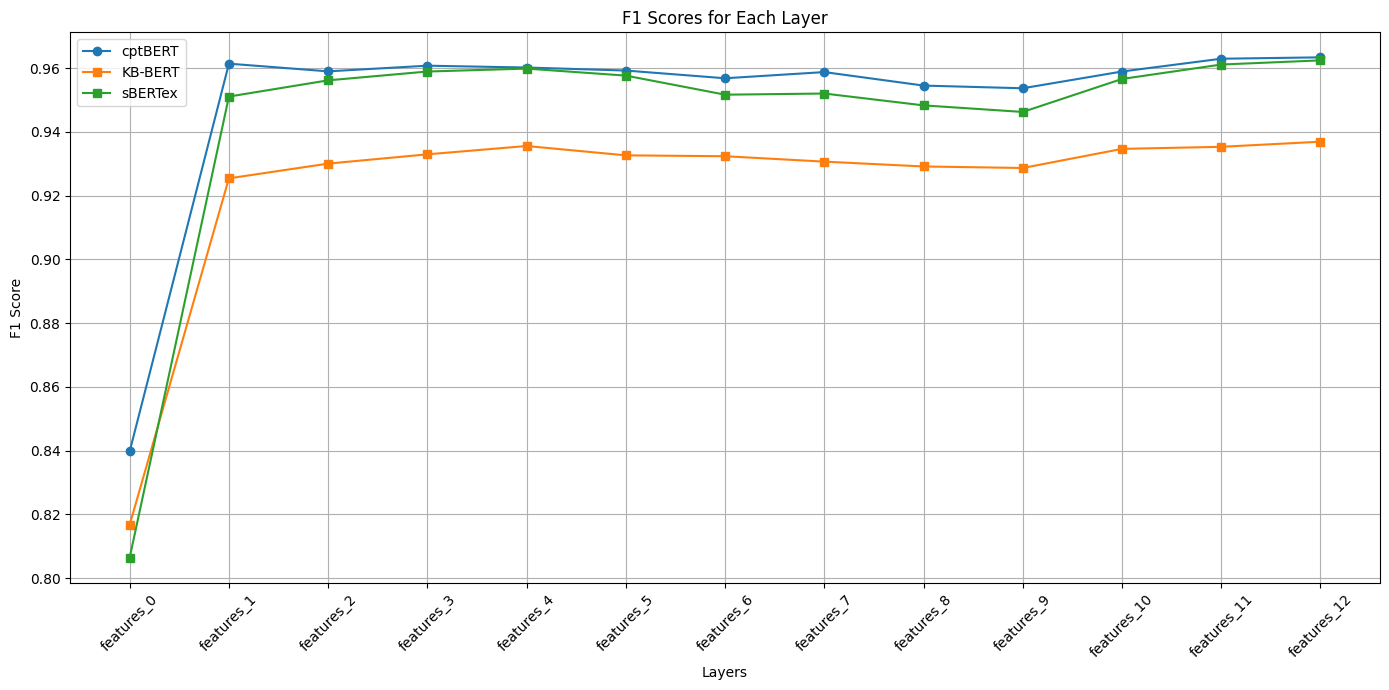

In [ ]:
layers = list(scores_cpt.keys())

test_scores_1 = [scores_cpt[layer][1] for layer in layers]
test_scores_2 = [scores_kb[layer][1] for layer in layers]
test_scores_3 = [scores_eb[layer][1] for layer in layers]
##test_scores_4 = [scores_spa[layer][1] for layer in layers]

# Création des graphiques
plt.figure(figsize=(14, 7))


plt.plot(layers, test_scores_1, label='cptBERT', marker='o')
plt.plot(layers, test_scores_2, label='KB-BERT', marker='s')
plt.plot(layers, test_scores_3, label='sBERTex', marker='s')
#plt.plot(layers, test_scores_4, label='KB-BERT', marker='s')

plt.xlabel('Layers')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Layer')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
#Scalr mixing probing
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from sklearn.metrics import f1_score

class ScalarMix(nn.Module):
    def __init__(self, num_layers):
        super(ScalarMix, self).__init__()
        self.weights = nn.Parameter(torch.zeros(num_layers))
        self.gamma = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, layers):
        norm_weights = torch.nn.functional.softmax(self.weights, dim=0)
        mixed_representation = sum(w * layer for w, layer in zip(norm_weights, layers))
        return self.gamma * mixed_representation


class ProbingModel(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super(ProbingModel, self).__init__()
        self.scalar_mix = ScalarMix(num_layers)
        self.classifier = nn.Linear(hidden_size, 2)  # Assuming binary classification
    
    def forward(self, hidden_states):
        mixed_representation = self.scalar_mix(hidden_states)
        return self.classifier(mixed_representation)
    
    
def extract_features(example, model, tokenizer):
    inputs = tokenizer(example['Note'], return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs,output_hidden_states=True)
    hidden_states=outputs.hidden_states
    hidden_states =torch.stack([torch.mean(state, dim=1) for state in hidden_states], dim=0).cpu().numpy()
    example["hidden_states"]=hidden_states
    return example

def train_scalar_mix(train_dataset, model, criterion, optimizer, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in train_dataset:
            optimizer.zero_grad()
            hidden_states = torch.tensor(example['hidden_states']).to(device)
            labels = torch.tensor(example['reform']).to(device)
            
            outputs = model(hidden_states)
            print(outputs.shape)
            print(labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataset)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')
 
 
def evaluate(test_set,model,criterion):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for example in test_dataset:
            hidden_states = torch.tensor(example['hidden_states']).to(device)
            labels = torch.tensor(example['reform']).to(device)
            
            outputs = model(hidden_states)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    return test_f1
    
    
num_layers = 13  # For BERT base model
hidden_size = 768  # Hidden size for BERT base model
model_probe_kb = ProbingModel(num_layers, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_probe_kb.parameters(), lr=1e-5)


encoded_dataset_train = Dataset.from_dict(date_dataset["train"][:10]).map(lambda example: extract_features(example, model_kb, tokenizer), batched=False)
encoded_dataset_test = Dataset.from_dict(date_dataset["test"][:10]).map(lambda example: extract_features(example, model_kb, tokenizer), batched=False)
train_dataloader = DataLoader(encoded_dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(encoded_dataset_test, batch_size=32, shuffle=False)

#train_scalar_mix(encoded_dataset_train, model_probe_kb, criterion, optimizer, num_epochs=3)


#scores_scalar = evaluate(encoded_dataset_test,model_probe_kb,criterion)


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [33]:
#train_scalar_mix(encoded_dataset_train, model_probe_kb, criterion, optimizer, num_epochs=3)


#scores_scalar = evaluate(encoded_dataset_test,model_probe_kb,criterion)

10


In [1]:
class Config:
    def __init__(self, bert_version, tokenizer):
        self.data_path_train = 'swerick_subsetdata_party_train.csv'
        self.data_path_test = 'swerick_subsetdata_party_test.csv'
        self.data_path_valid = 'swerick_subsetdata_party_test.csv'
        self.bert_version = bert_version
        self.tokenizer = tokenizer
        self.batch_size = 32
        self.epochs = 3
        self.hidden_size = 768
        self.learning_rate = 2e-5
        self.optimizer = 'adam'
        self.seed = 42
    
    
from evaluation.probing_experiments import GridLocProbeExperiment
config_kb = Config("KBLab/bert-base-swedish-cased","KBLab/bert-base-swedish-cased")
config_cpt = Config("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500","KBLab/bert-base-swedish-cased")
experiment_kb = GridLocProbeExperiment(config_kb)
experiment_cpt = GridLocProbeExperiment(config_cpt)

Some weights of BertModel were not initialized from the model checkpoint at finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
config_eb = Config("exbert-finetuned-imdb/checkpoint-6054000","exbert_tokenizer")
experiment_eb= GridLocProbeExperiment(config_eb)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of BertModel were not initialized from the model checkpoint at exbert-finetuned-imdb/checkpoint-6054000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
experiment_eb.probe()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:06<00:00,  5.02it/s]


Parameter containing:
tensor([-0.0006, -0.0006, -0.0006, -0.0006, -0.0006,  0.0002,  0.0006,  0.0006,
         0.0006,  0.0006,  0.0006,  0.0006,  0.0006], device='cuda:0',
       requires_grad=True)
Epoch 0: Test Accuracy: 0.2110, Test F1: 0.2100


100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


Parameter containing:
tensor([-0.0012, -0.0012, -0.0012, -0.0012, -0.0012,  0.0006,  0.0012,  0.0012,
         0.0012,  0.0011,  0.0012,  0.0012,  0.0012], device='cuda:0',
       requires_grad=True)
Epoch 1: Test Accuracy: 0.2700, Test F1: 0.2677


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


Parameter containing:
tensor([-0.0017, -0.0017, -0.0016, -0.0017, -0.0017,  0.0010,  0.0018,  0.0018,
         0.0017,  0.0016,  0.0016,  0.0017,  0.0017], device='cuda:0',
       requires_grad=True)
Epoch 2: Test Accuracy: 0.3790, Test F1: 0.3589


In [8]:
F1_kb,diff_kb =experiment_kb.cumulative_probe()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.16it/s]


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
Layer 0: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


Parameter containing:
tensor([-0.0012,  0.0012,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 1: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


Parameter containing:
tensor([ 0.0008,  0.0001, -0.0008,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 2: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


Parameter containing:
tensor([-0.0014, -0.0021, -0.0021,  0.0018,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 3: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


Parameter containing:
tensor([ 0.0003,  0.0007,  0.0006,  0.0002, -0.0011,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 4: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


Parameter containing:
tensor([ 0.0017,  0.0004,  0.0013,  0.0015, -0.0016, -0.0015,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 5: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Parameter containing:
tensor([ 0.0016,  0.0013,  0.0003,  0.0007,  0.0006, -0.0012, -0.0016,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 6: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Parameter containing:
tensor([-0.0016, -0.0017, -0.0018, -0.0017,  0.0018,  0.0018,  0.0017,  0.0016,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 7: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Parameter containing:
tensor([-0.0016, -0.0017, -0.0006,  0.0015,  0.0018,  0.0008, -0.0014, -0.0013,
         0.0010,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 8: Test Accuracy: 0.8510, Test F1: 0.4598
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Parameter containing:
tensor([ 5.0311e-05, -9.4654e-04, -1.9698e-03, -1.8309e-03,  1.6881e-03,
         1.8499e-03,  1.7281e-03,  1.7357e-03, -9.2054e-04, -1.1663e-03,
         0.0000e+00,  0.0000e+00,  0.0000e+00], device='cuda:0',
       requires_grad=True)
Layer 9: Test Accuracy: 0.8520, Test F1: 0.4667
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Parameter containing:
tensor([-0.0019, -0.0021,  0.0009,  0.0013,  0.0017,  0.0019,  0.0018,  0.0019,
        -0.0005, -0.0009, -0.0016,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 10: Test Accuracy: 0.4880, Test F1: 0.4254
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Parameter containing:
tensor([ 0.0016, -0.0005, -0.0009, -0.0020, -0.0018, -0.0017, -0.0016, -0.0017,
        -0.0006,  0.0020,  0.0019,  0.0019,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 11: Test Accuracy: 0.7080, Test F1: 0.5732
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.05it/s]


Parameter containing:
tensor([ 0.0014,  0.0013,  0.0008,  0.0008,  0.0010,  0.0001, -0.0005, -0.0015,
        -0.0012, -0.0007, -0.0002, -0.0003, -0.0009], device='cuda:0',
       requires_grad=True)
Layer 12: Test Accuracy: 0.8520, Test F1: 0.4600


In [7]:
F1_cpt,diff_cpt =experiment_cpt.cumulative_probe()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
Layer 0: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.19it/s]


Parameter containing:
tensor([ 0.0016, -0.0016,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 1: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.17it/s]


Parameter containing:
tensor([-0.0005, -0.0002,  0.0004,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 2: Test Accuracy: 0.1550, Test F1: 0.1379
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


Parameter containing:
tensor([ 0.0018,  0.0017, -0.0019, -0.0017,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 3: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


Parameter containing:
tensor([ 0.0018, -0.0010, -0.0019, -0.0009,  0.0001,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 4: Test Accuracy: 0.8510, Test F1: 0.4598
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


Parameter containing:
tensor([ 0.0020, -0.0016,  0.0018,  0.0017, -0.0020, -0.0021,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 5: Test Accuracy: 0.1480, Test F1: 0.1289
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


Parameter containing:
tensor([ 0.0018,  0.0018,  0.0017, -0.0017, -0.0018, -0.0018, -0.0018,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 6: Test Accuracy: 0.8360, Test F1: 0.4553
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


Parameter containing:
tensor([ 0.0014,  0.0016, -0.0006,  0.0011, -0.0013, -0.0015, -0.0015, -0.0014,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 7: Test Accuracy: 0.8530, Test F1: 0.4670
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Parameter containing:
tensor([-0.0016, -0.0016, -0.0017, -0.0010,  0.0009,  0.0016,  0.0017,  0.0015,
         0.0015,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 8: Test Accuracy: 0.6980, Test F1: 0.5511
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


Parameter containing:
tensor([-0.0017, -0.0017, -0.0018, -0.0017,  0.0017,  0.0017,  0.0017,  0.0017,
         0.0017,  0.0017,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 9: Test Accuracy: 0.5360, Test F1: 0.4977
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Parameter containing:
tensor([ 0.0016,  0.0017,  0.0016,  0.0014, -0.0013, -0.0016, -0.0017, -0.0016,
        -0.0016, -0.0016, -0.0016,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 10: Test Accuracy: 0.8510, Test F1: 0.4598
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Parameter containing:
tensor([-0.0013, -0.0017, -0.0017, -0.0018, -0.0007,  0.0010,  0.0018,  0.0018,
         0.0019,  0.0018,  0.0002, -0.0018,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 11: Test Accuracy: 0.2450, Test F1: 0.2441
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Parameter containing:
tensor([ 0.0018,  0.0018,  0.0016, -0.0006,  0.0017,  0.0014,  0.0015,  0.0017,
        -0.0010, -0.0017, -0.0017, -0.0017,  0.0007], device='cuda:0',
       requires_grad=True)
Layer 12: Test Accuracy: 0.7530, Test F1: 0.6297


In [5]:
F1_eb,diff_eb =experiment_eb.cumulative_probe()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.20it/s]


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
Layer 0: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.19it/s]


Parameter containing:
tensor([-0.0015,  0.0015,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 1: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.16it/s]


Parameter containing:
tensor([-0.0004,  0.0018, -0.0015,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 2: Test Accuracy: 0.8560, Test F1: 0.4874
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


Parameter containing:
tensor([-0.0020, -0.0012,  0.0011,  0.0019,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 3: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


Parameter containing:
tensor([ 0.0018,  0.0020, -0.0017, -0.0019, -0.0019,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 4: Test Accuracy: 0.2110, Test F1: 0.1993
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


Parameter containing:
tensor([-0.0010,  0.0004, -0.0013,  0.0017,  0.0013, -0.0012,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 5: Test Accuracy: 0.8510, Test F1: 0.4598
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


Parameter containing:
tensor([ 0.0017,  0.0019, -0.0008, -0.0012, -0.0016, -0.0014, -0.0014,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 6: Test Accuracy: 0.8390, Test F1: 0.4562
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Parameter containing:
tensor([ 5.1661e-05, -7.8638e-04, -1.3557e-03,  2.8555e-04,  6.2588e-04,
         2.3888e-04,  1.0593e-04,  5.2343e-04,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], device='cuda:0',
       requires_grad=True)
Layer 7: Test Accuracy: 0.8560, Test F1: 0.4935
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


Parameter containing:
tensor([ 0.0003,  0.0016,  0.0015,  0.0013,  0.0015,  0.0016, -0.0011, -0.0016,
        -0.0016,  0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 8: Test Accuracy: 0.8540, Test F1: 0.5041
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Parameter containing:
tensor([ 0.0014,  0.0005, -0.0007, -0.0005,  0.0006,  0.0002, -0.0010, -0.0006,
        -0.0007, -0.0003,  0.0000,  0.0000,  0.0000], device='cuda:0',
       requires_grad=True)
Layer 9: Test Accuracy: 0.8510, Test F1: 0.4598
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Parameter containing:
tensor([ 4.6451e-04,  3.5028e-04,  7.0254e-04, -6.0853e-04, -1.6102e-03,
        -1.4927e-03, -1.0490e-03, -2.5672e-05, -6.5893e-05,  1.7399e-03,
         1.5154e-03,  0.0000e+00,  0.0000e+00], device='cuda:0',
       requires_grad=True)
Layer 10: Test Accuracy: 0.8520, Test F1: 0.4600
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Parameter containing:
tensor([ 1.5864e-03,  1.5722e-03,  5.6968e-04,  1.5025e-03,  1.7740e-03,
        -5.3796e-04, -7.4905e-04,  5.3366e-04,  3.1388e-05, -1.6738e-03,
        -1.6850e-03, -1.6136e-03,  0.0000e+00], device='cuda:0',
       requires_grad=True)
Layer 11: Test Accuracy: 0.8510, Test F1: 0.5132
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


100%|██████████| 32/32 [00:06<00:00,  5.05it/s]


Parameter containing:
tensor([ 7.8736e-04,  1.1116e-03,  3.2873e-04, -5.6149e-04,  1.2723e-03,
        -3.4998e-04, -4.7844e-04, -5.2288e-04, -1.3284e-03, -2.5528e-05,
         8.1228e-04, -5.1320e-04, -1.5620e-03], device='cuda:0',
       requires_grad=True)
Layer 12: Test Accuracy: 0.8520, Test F1: 0.4794


In [ ]:
[ 0.0017,  0.0016,  0.0016,  0.0016,  0.0016,  0.0014,  0.0011, -0.0010,
        -0.0014, -0.0016, -0.0017, -0.0017, -0.0016],

In [8]:
experiment_cpt.probe()

100%|██████████| 32/32 [00:06<00:00,  5.18it/s]


Epoch 0: Valid Accuracy: 0.8540, Valid F1: 0.4739
Epoch 0: Test Accuracy: 0.8540, Test F1: 0.4739


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


Epoch 1: Valid Accuracy: 0.8530, Valid F1: 0.4670
Epoch 1: Test Accuracy: 0.8530, Test F1: 0.4670


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


Epoch 2: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 2: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Epoch 3: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 3: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Epoch 4: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 4: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


Epoch 5: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 5: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


Epoch 6: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 6: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


Epoch 7: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 7: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Epoch 8: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 8: Test Accuracy: 0.8520, Test F1: 0.4600


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Epoch 9: Valid Accuracy: 0.8520, Valid F1: 0.4600
Epoch 9: Test Accuracy: 0.8520, Test F1: 0.4600


In [33]:
def center_of_gravity(weights, num_layers):
    return np.sum([l * weights[l] for l in range(num_layers)])

cog_kb = center_of_gravity(weights_kb, num_layers)
cog_cpt = center_of_gravity(weights_cpt, num_layers)
cog_eb = center_of_gravity(weights_eb, num_layers)

print(f"Center of Gravity for KBBERT: {cog_kb:.2f}")
print(f"Center of Gravity for cptBERT: {cog_cpt:.2f}")
print(f"Center of Gravity for sBERTex: {cog_eb:.2f}")

Center of Gravity for KBBERT: 6.01
Center of Gravity for cptBERT: 6.01
Center of Gravity for sBERTex: 6.01


13


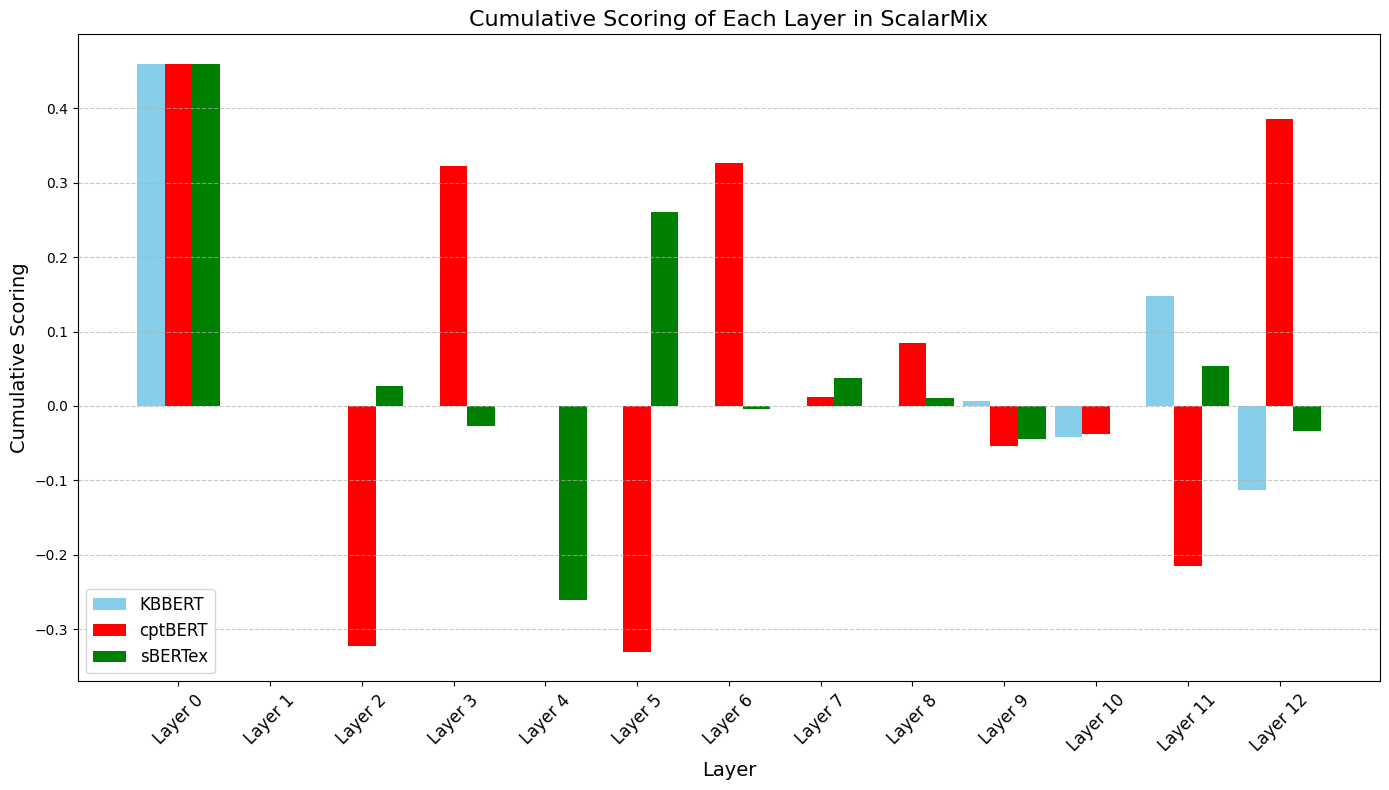

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# diff_kb = [0.46004319654427644,
#   -0.33112333591709875,
#   0.33112333591709875,
#   -0.3298386055372046,
#   0.3298386055372046,
#   0.0,
#   0.08323349160849319,
#   -0.08323349160849319,
#   0.0,
#   0.0,
#   0.0,
#   0.0,
#   0.0]

num_layers = len(diff_kb)
print(num_layers)
plt.figure(figsize=(14, 8))
positions_kb = np.arange(num_layers)
bar_width=0.3
positions_kb = np.arange(num_layers)
positions_cpt = positions_kb + bar_width
positions_eb = positions_cpt + bar_width

plt.bar(np.arange(num_layers),diff_kb,width=bar_width,color='skyblue', label='KBBERT')
plt.bar(positions_cpt,diff_cpt,color='red',width=bar_width, label='cptBERT')
plt.bar(positions_eb,diff_eb,color='green',width=bar_width ,label='sBERTex')
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Cumulative Scoring', fontsize=14)
plt.title('Cumulative Scoring of Each Layer in ScalarMix', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

layer_labels = [f'Layer {i}' for i in range(num_layers)]
plt.xticks(positions_kb + bar_width, labels=layer_labels, fontsize=12,rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

        

/tmp/ipykernel_809095/51561001.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights_eb_bis=torch.nn.functional.softmax(torch.tensor([-0.0017, -0.0017, -0.0015,  0.0019, -0.0006,  0.0018,  0.0017,  0.0017,


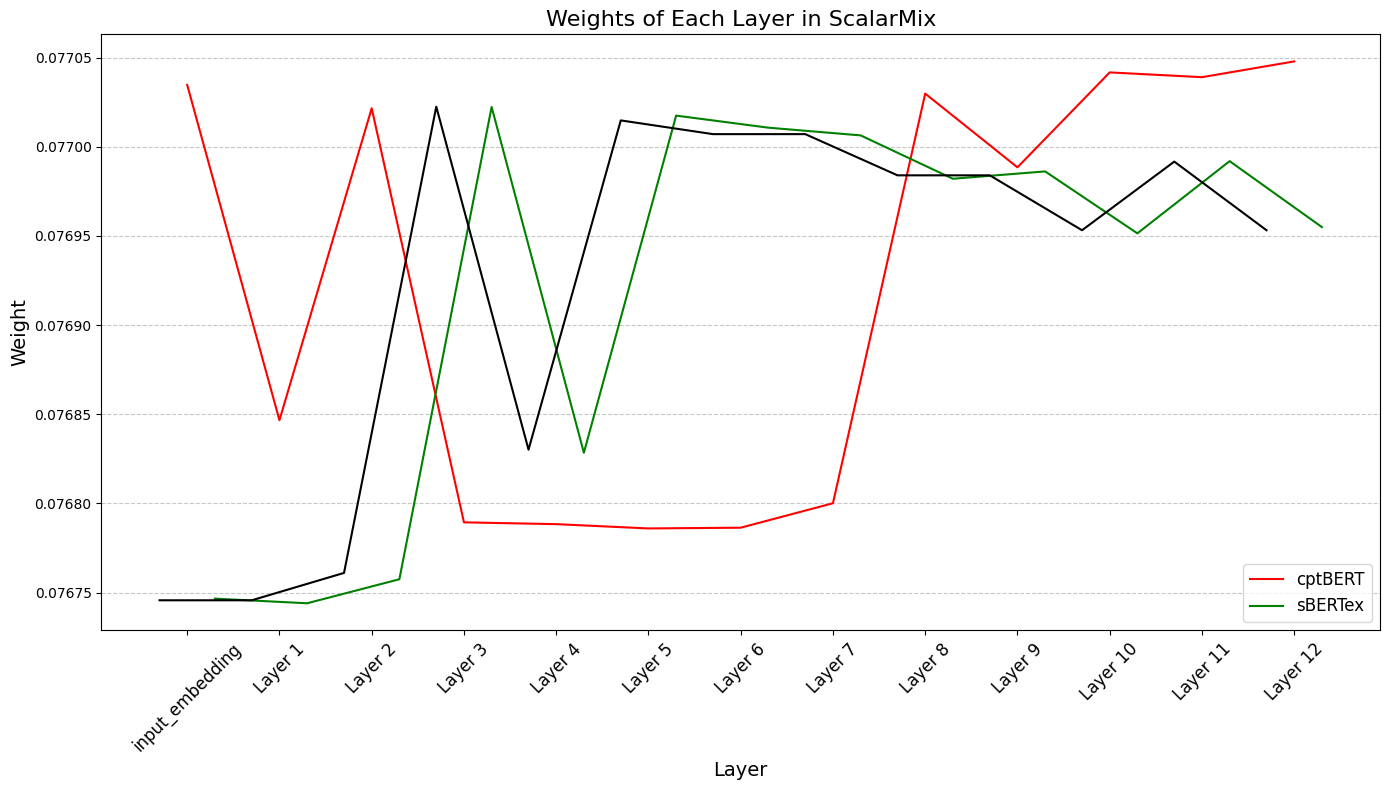

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# Assurez-vous que les poids sont extraits correctement
weights_kb = torch.nn.functional.softmax(experiment_kb.model.weights.detach(), dim=0).cpu().numpy()
weights_cpt = torch.nn.functional.softmax(experiment_cpt.model.weights.detach(), dim=0).cpu().numpy()
weights_eb_bis=torch.nn.functional.softmax(torch.tensor([-0.0017, -0.0017, -0.0015,  0.0019, -0.0006,  0.0018,  0.0017,  0.0017,
         0.0014,  0.0014,  0.0010,  0.0015,  0.0010]))
weights_eb = torch.nn.functional.softmax(experiment_eb.model.weights.detach(), dim=0).cpu().numpy()

# Number of layers
num_layers = len(weights_kb)

# Set the width of the bars
bar_width = 0.3

# Set the positions of the bars
positions_kb = np.arange(num_layers)
#positions_cpt = positions_kb + bar_width
#positions_eb = positions_cpt + bar_width

# Create the plot
plt.figure(figsize=(14, 8))
#bars_kb = plt.plot(positions_kb, weights_kb, color='skyblue', label='KBBERT')
bars_cpt = plt.plot(positions_cpt, weights_cpt,color='red', label='cptBERT')
bars_eb = plt.plot(positions_eb, weights_eb, color='green', label='sBERTex')
bar_eb_bis=plt.plot(positions_kb,weights_eb_bis,color='black')
# Add labels and title
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Weights of Each Layer in ScalarMix', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

layer_labels = ['input_embedding'] + [f'Layer {i}' for i in range(1, num_layers)]
plt.xticks(positions_kb + bar_width, labels=layer_labels, fontsize=12,rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#CUmulative scoring


